## LSTM model ##

- This is an exploratory notebook to find the best hyperparameters for the model so that it is not overfitting neither is it underfitting

#### Fourier transforms####

- eliminate noise and create approximations of the real stock movement.
- creates a series of sine waves with different amplitudes and frames. Wen combined, these sine waves approximate the original function. 
- we use them to extract global and local trends in the stock price.

#### Stacked autoencoders ####

- to find the missing correlations, we can find new types of features that affect stock movements. 
- Autoencode is a neural network model that seeks to learn a compressed representation of an input.
    - They are unsupervised but are trained with supervised learning methods. They are typically trained as part of a broader model that attemps to recreate the input.
    - They have a design with a bottleneck at the midpoint from which the reconstruction of the input data is performed. 
    - The most commong use isa learned or automatic feature extraction model.
    - We can take the data up until the bottleneck and use that as a fixed length vector that provides a compressed representation of hte input data, can be used for supervised learning model, visualization or more generally for dimensionality reduction.
  #### LSTM Autoencoder:
      - Implementation of autoencoder for sequence data usin and Encoder- Decoder LSTM architecture.
      - an encoder-decoder LSTM is configured to read the input sequence, encode it, decode it, and recreate it. The performance is evaluated based on the model's ability to recreate the input sequence.
      - When the model has a desired level of performance, the decoder part of the model may be removed and we will have just hte encoder part. 
      - Composite model: two decoders used to predict the next frame in the sequence and one to reconstruct frames in the sequence. 

##### steps:
- perform statistical checks for the 'quality' of the data. Make sure the data does not have heteroskedasticity, multicollinearity, or serial correlation.
- create feature importance, use XGBoost to do that.
- Heteroskedasticity: when the difference between predicted value by a regression and the real value is dependent on the data i.e. error grows when the data point grows along the x-axis.
- Serial Correlation: when one data is a formula of another feature.

##### PCA:
- reduce the dimensionality of the features created from autoencoders, using eigen portfolios



In [1]:
# To be crystal clear, the top of your code file must have the following 4 lines before any others;
from numpy.random import seed
seed(42)
from tensorflow import set_random_seed
set_random_seed(42)

In [2]:
!pip install python-decouple

You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [8]:
import pandas as pd
import numpy as np
import quandl
import datetime
from decouple import config
import math
# sklearn imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import matplotlib.pyplot as plt
# keras imports
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.layers import RepeatVector, TimeDistributed
# notebook imports
from fin_data_fundamentals import find_fundamentals
from fin_data_fundamentals import get_fundamentals
from alpha_vantage.foreignexchange import ForeignExchange
from alpha_vantage.techindicators import TechIndicators
from alpha_vantage.timeseries import TimeSeries
from fin_data import DailyTimeSeries
from fracdiff import FractionalDifferentiation as fd

In [9]:
from fin_data import DailyTimeSeries
import numpy as np
import pandas as pd
import os, sys
import matplotlib.pyplot as plt

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Let's pull in the data:

In [10]:
# We will experiment with Tesla stock

tesla = DailyTimeSeries('TSLA')

df = tesla.initiate()

################################################################### 
 Ticker:  TSLA 
 Last Refreshed:  2019-09-23 09:53:58 
 Data Retrieved:  Daily Time Series with Splits and Dividend Events 
 ###################################################################


In [11]:
df.head()

,TSLA_open,TSLA_high,TSLA_low,TSLA_close,TSLA_adjusted_close,TSLA_volume,TSLA_dividend_amount
date,,,,,,,
2010-06-29,19.00,24.9984,17.54,23.89,23.89,18766300.0,0.0
2010-06-30,25.79,30.4190,23.30,23.83,23.83,17187100.0,0.0
2010-07-01,25.00,25.9200,20.27,21.96,21.96,8218800.0,0.0
2010-07-02,23.00,23.0998,18.71,19.20,19.20,5139800.0,0.0
2010-07-06,20.00,20.0000,15.83,16.11,16.11,6866900.0,0.0


plt.figure(figsize=(20,12))

plt.plot(df['TSLA close'], color = 'teal')
plt.plot(df['5. adjusted close'], color = 'red');

#### Adding Indicators ##

Add indicators, technical, securities, and macro to the dataframe

In [12]:
# add the fundamentals,

fund_list = ["operatingrevenue", "totalrevenue", "netincome", "totaloperatingexpenses", "totalgrossprofit", "totaloperatingincome", "totalpretaxincome", "weightedavebasicdilutedsharesos", "cashdividendspershare", "totalcostofrevenue"]

# not a complete list of fundamentals that I can pull in from the API, but this is good so far.

In [13]:
df_fund = tesla.add_fundamentals(df, fund_list)

################################################################### 
 Ticker:  TSLA 
 Fundamentals Retrieved:  ['TSLA_open' 'TSLA_high' 'TSLA_low' 'TSLA_close' 'TSLA_adjusted_close'
 'TSLA_volume' 'TSLA_dividend_amount' 'TSLA_operatingrevenue'
 'TSLA_totalrevenue' 'TSLA_netincome' 'TSLA_totaloperatingexpenses'
 'TSLA_totalgrossprofit' 'TSLA_totaloperatingincome'
 'TSLA_totalpretaxincome' 'TSLA_weightedavebasicdilutedsharesos'
 'TSLA_cashdividendspershare' 'TSLA_totalcostofrevenue'] 
 ###################################################################
################################################################### 
 Ticker:  TSLA 
 Retrieved Data Start Date:  2011-11-14 
 Retrieved Data End Date:  2019-07-29 
 Data Retrieved:  ['TSLA_operatingrevenue', 'TSLA_totalrevenue', 'TSLA_netincome', 'TSLA_totaloperatingexpenses', 'TSLA_totalgrossprofit', 'TSLA_totaloperatingincome', 'TSLA_totalpretaxincome', 'TSLA_weightedavebasicdilutedsharesos', 'TSLA_cashdividendspershare', 'TSLA_totalcos

In [14]:
funs = ['totalrevenue',  'totalcostofrevenue', 'totalgrossprofit', 'totalpretaxincome', 'weightedavebasicdilutedsharesos', 'cashdividendspershare']
techs = ['SMA', 'WMA', 'STOCH', 'ROC', 'AROON']
macros = ['housing_index', 'confidence_index', 'trade_index', 'longterm_rates', 'shortterm_rates']

In [15]:
df_fund.head()

,TSLA_open,TSLA_high,TSLA_low,TSLA_close,TSLA_adjusted_close,TSLA_volume,TSLA_dividend_amount,TSLA_operatingrevenue,TSLA_totalrevenue,TSLA_netincome,TSLA_totaloperatingexpenses,TSLA_totalgrossprofit,TSLA_totaloperatingincome,TSLA_totalpretaxincome,TSLA_weightedavebasicdilutedsharesos,TSLA_cashdividendspershare,TSLA_totalcostofrevenue
date,,,,,,,,,,,,,,,,,
2010-06-29,19.00,24.9984,17.54,23.89,23.89,18766300.0,0.0,31241000.0,31241000.0,-34935000.0,47130000.0,9296000.0,-37834000.0,-34852000.0,92270721.0,0.0,21945000.0
2010-06-30,25.79,30.4190,23.30,23.83,23.83,17187100.0,0.0,31241000.0,31241000.0,-34935000.0,47130000.0,9296000.0,-37834000.0,-34852000.0,92270721.0,0.0,21945000.0
2010-07-01,25.00,25.9200,20.27,21.96,21.96,8218800.0,0.0,31241000.0,31241000.0,-34935000.0,47130000.0,9296000.0,-37834000.0,-34852000.0,92270721.0,0.0,21945000.0
2010-07-02,23.00,23.0998,18.71,19.20,19.20,5139800.0,0.0,31241000.0,31241000.0,-34935000.0,47130000.0,9296000.0,-37834000.0,-34852000.0,92270721.0,0.0,21945000.0
2010-07-06,20.00,20.0000,15.83,16.11,16.11,6866900.0,0.0,31241000.0,31241000.0,-34935000.0,47130000.0,9296000.0,-37834000.0,-34852000.0,92270721.0,0.0,21945000.0


In [16]:
# Add data with all the indicators:

def tech_company_data(ticker):
    """
    Containes Tech Index
    """    
    dts = DailyTimeSeries(ticker)
    df = dts.initiate()
    with HiddenPrints():
        df = dts.add_securities(['XLK', 'vix', 'SPX'], primary_df=df)
        df = dts.add_technicals(['SMA', 'EMA', 'MACD', 'STOCH', 
                                   'RSI', 'ADX', 'CCI', 'BBANDS', 
                                   'AD', 'OBV'], 
                                  primary_df=df)
        df = dts.add_macro(primary_df=df, 
                             indices=['housing_index', 'confidence_index', 'trade_index', 'longterm_rates'])
    
    return df

In [17]:
df = tech_company_data('TSLA')


################################################################### 
 Ticker:  TSLA 
 Last Refreshed:  2019-09-23 09:54:03 
 Data Retrieved:  Daily Time Series with Splits and Dividend Events 
 ###################################################################


/home/ec2-user/SageMaker/fin_data.py:276: UserWarning: The latest value available for Housing Index is from January 2019.
  warnings.warn("The latest value available for Housing Index is from January 2019.")


In [18]:
df.head()

,TSLA_open,TSLA_high,TSLA_low,TSLA_close,TSLA_adjusted_close,TSLA_volume,TSLA_dividend_amount,XLK_open,XLK_high,XLK_low,XLK_close,XLK_adjusted_close,XLK_volume,XLK_dividend_amount,XLK_split_coefficient,vix_open,vix_high,vix_low,vix_close,vix_adjusted_close,vix_volume,vix_dividend_amount,vix_split_coefficient,SPX_open,SPX_high,SPX_low,SPX_close,SPX_adjusted_close,SPX_volume,SPX_dividend_amount,SPX_split_coefficient,TSLA_SMA,TSLA_EMA,TSLA_MACD,TSLA_MACD_Hist,TSLA_MACD_Signal,TSLA_SlowD,TSLA_SlowK,TSLA_RSI,TSLA_ADX,TSLA_CCI,TSLA_Real Middle Band,TSLA_Real Upper Band,TSLA_Real Lower Band,TSLA_Chaikin A/D,TSLA_OBV,housing_index,conf_index,conf_index_SE,trade_value,10 Yrs Rates,20-Yr Maturity Rate
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-08-24,19.25,19.710,18.95,19.20,19.20,673100.0,0.0,20.93,21.079,20.77,20.87,17.9672,10590300.0,0.0,1.0,27.91,28.77,26.32,27.46,27.46,0.0,0.0,1.0,1063.20,1063.20,1046.6801,1051.87,1051.87,4.436330e+09,0.0,1.0,19.5775,19.3641,-0.1483,-0.0444,-0.1039,65.1365,64.2590,43.3780,4.5065,-21.9384,19.5775,21.7879,17.3671,-5.397985e+06,-12174000.0,147.552,63.87,3.48,102.4331,3.17,3.28
2010-08-25,19.16,19.980,18.56,19.90,19.90,503300.0,0.0,20.74,21.090,20.69,21.00,18.0791,11052900.0,0.0,1.0,28.30,28.92,26.46,26.70,26.70,0.0,0.0,1.0,1048.98,1059.38,1039.8300,1055.33,1055.33,4.360190e+09,0.0,1.0,19.5365,19.4152,-0.0853,0.0149,-0.1001,67.5305,68.6417,46.1348,4.5061,-3.2187,19.5365,21.6903,17.3827,-4.951395e+06,-11670700.0,147.552,63.87,3.48,102.9749,3.20,3.31
2010-08-26,19.89,20.270,19.60,19.75,19.75,433800.0,0.0,21.10,21.130,20.76,20.79,17.8983,10154700.0,0.0,1.0,26.45,27.55,25.86,27.37,27.37,0.0,0.0,1.0,1056.28,1061.45,1045.4000,1047.22,1047.22,3.646710e+09,0.0,1.0,19.5065,19.4471,-0.0469,0.0426,-0.0895,64.7999,61.4989,45.6336,4.6097,31.2156,19.5065,21.6307,17.3823,-5.190957e+06,-12104500.0,147.552,63.87,3.48,102.9749,3.15,3.25
2010-08-27,19.75,19.865,19.50,19.70,19.70,379600.0,0.0,20.91,21.050,20.58,21.04,18.1136,14991700.0,0.0,1.0,26.50,28.11,24.41,24.45,24.45,0.0,0.0,1.0,1049.27,1065.21,1039.7000,1064.59,1064.59,4.102460e+09,0.0,1.0,19.4945,19.4711,-0.0203,0.0554,-0.0757,66.1105,68.1908,45.4603,4.6664,17.5294,19.4945,21.6114,17.3776,-5.154557e+06,-12484100.0,147.552,63.87,3.48,102.9749,3.31,3.41
2010-08-30,19.70,20.190,19.61,19.87,19.87,732800.0,0.0,20.93,21.090,20.76,20.76,17.8725,7593500.0,0.0,1.0,25.88,27.21,25.41,27.21,27.21,0.0,0.0,1.0,1062.90,1064.40,1048.7900,1048.92,1048.92,2.917990e+09,0.0,1.0,19.4420,19.5091,0.0144,0.0720,-0.0576,65.9999,68.3100,46.1916,4.8434,40.1607,19.4420,21.4649,17.4191,-5.230363e+06,-11751300.0,147.552,63.87,3.48,102.9749,3.19,3.30


In [19]:

df.shape

(2124, 52)

In [20]:
df = tech_company_data('TSLA')

################################################################### 
 Ticker:  TSLA 
 Last Refreshed:  2019-09-23 09:54:23 
 Data Retrieved:  Daily Time Series with Splits and Dividend Events 
 ###################################################################


/home/ec2-user/SageMaker/fin_data.py:276: UserWarning: The latest value available for Housing Index is from January 2019.
  warnings.warn("The latest value available for Housing Index is from January 2019.")


In [21]:
df.tail()

,TSLA_open,TSLA_high,TSLA_low,TSLA_close,TSLA_adjusted_close,TSLA_volume,TSLA_dividend_amount,XLK_open,XLK_high,XLK_low,XLK_close,XLK_adjusted_close,XLK_volume,XLK_dividend_amount,XLK_split_coefficient,vix_open,vix_high,vix_low,vix_close,vix_adjusted_close,vix_volume,vix_dividend_amount,vix_split_coefficient,SPX_open,SPX_high,SPX_low,SPX_close,SPX_adjusted_close,SPX_volume,SPX_dividend_amount,SPX_split_coefficient,TSLA_SMA,TSLA_EMA,TSLA_MACD_Hist,TSLA_MACD_Signal,TSLA_MACD,TSLA_SlowD,TSLA_SlowK,TSLA_RSI,TSLA_ADX,TSLA_CCI,TSLA_Real Middle Band,TSLA_Real Upper Band,TSLA_Real Lower Band,TSLA_Chaikin A/D,TSLA_OBV,housing_index,conf_index,conf_index_SE,trade_value,10 Yrs Rates,20-Yr Maturity Rate
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-25,294.39,298.519,289.5336,297.04,297.04,7249600.0,0.0,65.5000,66.125,65.2600,65.93,65.4863,10030800.0,0.0,1.0,18.43,18.46,17.31,17.42,17.42,0.0,0.0,1.0,2657.4399,2672.3799,2657.3301,2664.7600,2664.7600,3.814080e+09,0.0,1.0,323.0775,320.5019,-4.6281,-4.8971,-9.5253,12.5661,20.8115,42.2487,14.5290,-99.7449,323.0775,363.6159,282.5391,2.407701e+08,292711900.0,205.073,54.48,4.30,126.8701,2.99,2.92
2019-01-28,292.91,297.460,287.7500,296.38,296.38,6423300.0,0.0,64.9500,65.070,64.5100,65.05,64.6122,9662400.0,0.0,1.0,18.56,20.42,18.42,18.87,18.87,0.0,0.0,1.0,2644.9700,2644.9700,2624.0601,2643.8501,2643.8501,3.612810e+09,0.0,1.0,322.0900,318.2045,-4.2533,-5.9604,-10.2138,23.0432,37.8597,42.1009,15.0068,-94.8844,322.0900,364.1894,279.9906,2.457645e+08,286288600.0,205.073,54.48,4.30,126.8701,2.99,2.92
2019-01-29,295.27,298.557,291.8000,297.46,297.46,4621700.0,0.0,65.1863,65.190,64.2500,64.35,63.9169,8573900.0,0.0,1.0,19.45,19.93,18.42,19.13,19.13,0.0,0.0,1.0,2644.8899,2650.9299,2631.0500,2640.0000,2640.0000,3.504200e+09,0.0,1.0,320.2695,316.2289,-3.6722,-6.8785,-10.5507,40.7745,63.6522,42.4477,15.4161,-78.3910,320.2695,363.3122,277.2268,2.488855e+08,290910300.0,205.073,54.48,4.30,126.8701,2.97,2.90
2019-01-30,300.45,309.000,298.4900,308.77,308.77,11250300.0,0.0,65.4200,66.540,65.1298,66.35,65.9035,16995300.0,0.0,1.0,19.15,19.31,17.54,17.66,17.66,0.0,0.0,1.0,2653.6201,2690.4399,2648.3401,2681.0500,2681.0500,3.857810e+09,0.0,1.0,319.0680,315.5185,-2.3309,-7.4612,-9.7922,61.9563,84.3569,46.0115,15.3913,-42.5230,319.0680,361.9859,276.1501,2.596434e+08,302160600.0,205.073,54.48,4.30,126.5041,2.98,2.90
2019-01-31,301.00,311.564,294.0000,307.02,307.02,12569200.0,0.0,66.0100,66.640,65.8000,66.28,65.8339,18250900.0,0.0,1.0,17.39,17.72,16.54,16.57,16.57,0.0,0.0,1.0,2685.4900,2708.9500,2678.6499,2704.1001,2704.1001,4.917650e+09,0.0,1.0,318.9130,314.7091,-1.4117,-7.8142,-9.2259,79.8312,91.4844,45.5521,15.4932,-45.5840,318.9130,361.9811,275.8449,2.657091e+08,289591400.0,204.708,47.93,3.84,126.5041,2.91,2.83


In [22]:
# merge the df and df_fund data together

df_new = pd.merge(df, df_fund, on='date')

df_new.head()


,TSLA_open_x,TSLA_high_x,TSLA_low_x,TSLA_close_x,TSLA_adjusted_close_x,TSLA_volume_x,TSLA_dividend_amount_x,XLK_open,XLK_high,XLK_low,XLK_close,XLK_adjusted_close,XLK_volume,XLK_dividend_amount,XLK_split_coefficient,vix_open,vix_high,vix_low,vix_close,vix_adjusted_close,vix_volume,vix_dividend_amount,vix_split_coefficient,SPX_open,SPX_high,SPX_low,SPX_close,SPX_adjusted_close,SPX_volume,SPX_dividend_amount,SPX_split_coefficient,TSLA_SMA,TSLA_EMA,TSLA_MACD_Hist,TSLA_MACD_Signal,TSLA_MACD,TSLA_SlowD,TSLA_SlowK,TSLA_RSI,TSLA_ADX,TSLA_CCI,TSLA_Real Middle Band,TSLA_Real Upper Band,TSLA_Real Lower Band,TSLA_Chaikin A/D,TSLA_OBV,housing_index,conf_index,conf_index_SE,trade_value,10 Yrs Rates,20-Yr Maturity Rate,TSLA_open_y,TSLA_high_y,TSLA_low_y,TSLA_close_y,TSLA_adjusted_close_y,TSLA_volume_y,TSLA_dividend_amount_y,TSLA_operatingrevenue,TSLA_totalrevenue,TSLA_netincome,TSLA_totaloperatingexpenses,TSLA_totalgrossprofit,TSLA_totaloperatingincome,TSLA_totalpretaxincome,TSLA_weightedavebasicdilutedsharesos,TSLA_cashdividendspershare,TSLA_totalcostofrevenue
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-08-24,19.25,19.710,18.95,19.20,19.20,673100.0,0.0,20.93,21.079,20.77,20.87,17.9672,10590300.0,0.0,1.0,27.91,28.77,26.32,27.46,27.46,0.0,0.0,1.0,1063.20,1063.20,1046.6801,1051.87,1051.87,4.436330e+09,0.0,1.0,19.5775,19.3641,-0.0444,-0.1039,-0.1483,65.1365,64.2590,43.3780,4.5065,-21.9384,19.5775,21.7879,17.3671,-5.397985e+06,-12174000.0,147.552,63.87,3.48,102.4331,3.17,3.28,19.25,19.710,18.95,19.20,19.20,673100.0,0.0,31241000.0,31241000.0,-34935000.0,47130000.0,9296000.0,-37834000.0,-34852000.0,92270721.0,0.0,21945000.0
2010-08-25,19.16,19.980,18.56,19.90,19.90,503300.0,0.0,20.74,21.090,20.69,21.00,18.0791,11052900.0,0.0,1.0,28.30,28.92,26.46,26.70,26.70,0.0,0.0,1.0,1048.98,1059.38,1039.8300,1055.33,1055.33,4.360190e+09,0.0,1.0,19.5365,19.4152,0.0149,-0.1001,-0.0853,67.5305,68.6417,46.1348,4.5061,-3.2187,19.5365,21.6903,17.3827,-4.951395e+06,-11670700.0,147.552,63.87,3.48,102.9749,3.20,3.31,19.16,19.980,18.56,19.90,19.90,503300.0,0.0,31241000.0,31241000.0,-34935000.0,47130000.0,9296000.0,-37834000.0,-34852000.0,92270721.0,0.0,21945000.0
2010-08-26,19.89,20.270,19.60,19.75,19.75,433800.0,0.0,21.10,21.130,20.76,20.79,17.8983,10154700.0,0.0,1.0,26.45,27.55,25.86,27.37,27.37,0.0,0.0,1.0,1056.28,1061.45,1045.4000,1047.22,1047.22,3.646710e+09,0.0,1.0,19.5065,19.4471,0.0426,-0.0895,-0.0469,64.7999,61.4989,45.6336,4.6097,31.2156,19.5065,21.6307,17.3823,-5.190957e+06,-12104500.0,147.552,63.87,3.48,102.9749,3.15,3.25,19.89,20.270,19.60,19.75,19.75,433800.0,0.0,31241000.0,31241000.0,-34935000.0,47130000.0,9296000.0,-37834000.0,-34852000.0,92270721.0,0.0,21945000.0
2010-08-27,19.75,19.865,19.50,19.70,19.70,379600.0,0.0,20.91,21.050,20.58,21.04,18.1136,14991700.0,0.0,1.0,26.50,28.11,24.41,24.45,24.45,0.0,0.0,1.0,1049.27,1065.21,1039.7000,1064.59,1064.59,4.102460e+09,0.0,1.0,19.4945,19.4711,0.0554,-0.0757,-0.0203,66.1105,68.1908,45.4603,4.6664,17.5294,19.4945,21.6114,17.3776,-5.154557e+06,-12484100.0,147.552,63.87,3.48,102.9749,3.31,3.41,19.75,19.865,19.50,19.70,19.70,379600.0,0.0,31241000.0,31241000.0,-34935000.0,47130000.0,9296000.0,-37834000.0,-34852000.0,92270721.0,0.0,21945000.0
2010-08-30,19.70,20.190,19.61,19.87,19.87,732800.0,0.0,20.93,21.090,20.76,20.76,17.8725,7593500.0,0.0,1.0,25.88,27.21,25.41,27.21,27.21,0.0,0.0,1.0,1062.90,1064.40,1048.7900,1048.92,1048.92,2.917990e+09,0.0,1.0,19.4420,19.5091,0.0720,-0.0576,0.0144,65.9999,68.3100,46.1916,4.8434,40.1607,19.4420,21.4649,17.4191,-5.230363e+06,-11751300.0,147.552,63.87,3.48,102.9749,3.19,3.30,19.70,20.190,19.61,19.87,19.87,732800.0,0.0,31241000.0,31241000.0,-34935000.0,47130000.0,9296000.0,-37834000.0,-34852000.0,92270721.0,0.0,21945000.0


Finally, the new dataframe has all the columns and indicators that we were initially planning on using. Let's move forward from here.

In [23]:
print('There are {} number of days in the dataset.'.format(df_new.shape[0]))

There are 2124 number of days in the dataset.


### Target & Split

We will use the adjusted close shift by 1 day for now.

We will then split the dataframe into X and y and further training and testing sets.

In [ ]:
# df['percent_change'] = ((df['TSLAclose'].shift(-1) - df['TSLA close']) / (df['TSLA close']))*100


In [26]:
#df['percent_change'].head()

In [27]:
df_new.head()

,TSLA_open_x,TSLA_high_x,TSLA_low_x,TSLA_close_x,TSLA_adjusted_close_x,TSLA_volume_x,TSLA_dividend_amount_x,XLK_open,XLK_high,XLK_low,XLK_close,XLK_adjusted_close,XLK_volume,XLK_dividend_amount,XLK_split_coefficient,vix_open,vix_high,vix_low,vix_close,vix_adjusted_close,vix_volume,vix_dividend_amount,vix_split_coefficient,SPX_open,SPX_high,SPX_low,SPX_close,SPX_adjusted_close,SPX_volume,SPX_dividend_amount,SPX_split_coefficient,TSLA_SMA,TSLA_EMA,TSLA_MACD_Hist,TSLA_MACD_Signal,TSLA_MACD,TSLA_SlowD,TSLA_SlowK,TSLA_RSI,TSLA_ADX,TSLA_CCI,TSLA_Real Middle Band,TSLA_Real Upper Band,TSLA_Real Lower Band,TSLA_Chaikin A/D,TSLA_OBV,housing_index,conf_index,conf_index_SE,trade_value,10 Yrs Rates,20-Yr Maturity Rate,TSLA_open_y,TSLA_high_y,TSLA_low_y,TSLA_close_y,TSLA_adjusted_close_y,TSLA_volume_y,TSLA_dividend_amount_y,TSLA_operatingrevenue,TSLA_totalrevenue,TSLA_netincome,TSLA_totaloperatingexpenses,TSLA_totalgrossprofit,TSLA_totaloperatingincome,TSLA_totalpretaxincome,TSLA_weightedavebasicdilutedsharesos,TSLA_cashdividendspershare,TSLA_totalcostofrevenue
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-08-24,19.25,19.710,18.95,19.20,19.20,673100.0,0.0,20.93,21.079,20.77,20.87,17.9672,10590300.0,0.0,1.0,27.91,28.77,26.32,27.46,27.46,0.0,0.0,1.0,1063.20,1063.20,1046.6801,1051.87,1051.87,4.436330e+09,0.0,1.0,19.5775,19.3641,-0.0444,-0.1039,-0.1483,65.1365,64.2590,43.3780,4.5065,-21.9384,19.5775,21.7879,17.3671,-5.397985e+06,-12174000.0,147.552,63.87,3.48,102.4331,3.17,3.28,19.25,19.710,18.95,19.20,19.20,673100.0,0.0,31241000.0,31241000.0,-34935000.0,47130000.0,9296000.0,-37834000.0,-34852000.0,92270721.0,0.0,21945000.0
2010-08-25,19.16,19.980,18.56,19.90,19.90,503300.0,0.0,20.74,21.090,20.69,21.00,18.0791,11052900.0,0.0,1.0,28.30,28.92,26.46,26.70,26.70,0.0,0.0,1.0,1048.98,1059.38,1039.8300,1055.33,1055.33,4.360190e+09,0.0,1.0,19.5365,19.4152,0.0149,-0.1001,-0.0853,67.5305,68.6417,46.1348,4.5061,-3.2187,19.5365,21.6903,17.3827,-4.951395e+06,-11670700.0,147.552,63.87,3.48,102.9749,3.20,3.31,19.16,19.980,18.56,19.90,19.90,503300.0,0.0,31241000.0,31241000.0,-34935000.0,47130000.0,9296000.0,-37834000.0,-34852000.0,92270721.0,0.0,21945000.0
2010-08-26,19.89,20.270,19.60,19.75,19.75,433800.0,0.0,21.10,21.130,20.76,20.79,17.8983,10154700.0,0.0,1.0,26.45,27.55,25.86,27.37,27.37,0.0,0.0,1.0,1056.28,1061.45,1045.4000,1047.22,1047.22,3.646710e+09,0.0,1.0,19.5065,19.4471,0.0426,-0.0895,-0.0469,64.7999,61.4989,45.6336,4.6097,31.2156,19.5065,21.6307,17.3823,-5.190957e+06,-12104500.0,147.552,63.87,3.48,102.9749,3.15,3.25,19.89,20.270,19.60,19.75,19.75,433800.0,0.0,31241000.0,31241000.0,-34935000.0,47130000.0,9296000.0,-37834000.0,-34852000.0,92270721.0,0.0,21945000.0
2010-08-27,19.75,19.865,19.50,19.70,19.70,379600.0,0.0,20.91,21.050,20.58,21.04,18.1136,14991700.0,0.0,1.0,26.50,28.11,24.41,24.45,24.45,0.0,0.0,1.0,1049.27,1065.21,1039.7000,1064.59,1064.59,4.102460e+09,0.0,1.0,19.4945,19.4711,0.0554,-0.0757,-0.0203,66.1105,68.1908,45.4603,4.6664,17.5294,19.4945,21.6114,17.3776,-5.154557e+06,-12484100.0,147.552,63.87,3.48,102.9749,3.31,3.41,19.75,19.865,19.50,19.70,19.70,379600.0,0.0,31241000.0,31241000.0,-34935000.0,47130000.0,9296000.0,-37834000.0,-34852000.0,92270721.0,0.0,21945000.0
2010-08-30,19.70,20.190,19.61,19.87,19.87,732800.0,0.0,20.93,21.090,20.76,20.76,17.8725,7593500.0,0.0,1.0,25.88,27.21,25.41,27.21,27.21,0.0,0.0,1.0,1062.90,1064.40,1048.7900,1048.92,1048.92,2.917990e+09,0.0,1.0,19.4420,19.5091,0.0720,-0.0576,0.0144,65.9999,68.3100,46.1916,4.8434,40.1607,19.4420,21.4649,17.4191,-5.230363e+06,-11751300.0,147.552,63.87,3.48,102.9749,3.19,3.30,19.70,20.190,19.61,19.87,19.87,732800.0,0.0,31241000.0,31241000.0,-34935000.0,47130000.0,9296000.0,-37834000.0,-34852000.0,92270721.0,0.0,21945000.0


In [29]:
df_new['target'] = ((df_new['TSLA_close_x'].shift(-1)))
# df_new['target'] = ((df_new['TSLA_close_x'].shift(-1) - df_new['TSLA_close_x']) / (df_new['TSLA_close_x']))*100



In [30]:
df_new['target'].head()

date
2010-08-24    19.90
2010-08-25    19.75
2010-08-26    19.70
2010-08-27    19.87
2010-08-30    19.48
Name: target, dtype: float64

In [31]:
df_new.columns.tolist

<bound method IndexOpsMixin.tolist of Index(['TSLA_open_x', 'TSLA_high_x', 'TSLA_low_x', 'TSLA_close_x',
       'TSLA_adjusted_close_x', 'TSLA_volume_x', 'TSLA_dividend_amount_x',
       'XLK_open', 'XLK_high', 'XLK_low', 'XLK_close', 'XLK_adjusted_close',
       'XLK_volume', 'XLK_dividend_amount', 'XLK_split_coefficient',
       'vix_open', 'vix_high', 'vix_low', 'vix_close', 'vix_adjusted_close',
       'vix_volume', 'vix_dividend_amount', 'vix_split_coefficient',
       'SPX_open', 'SPX_high', 'SPX_low', 'SPX_close', 'SPX_adjusted_close',
       'SPX_volume', 'SPX_dividend_amount', 'SPX_split_coefficient',
       'TSLA_SMA', 'TSLA_EMA', 'TSLA_MACD_Hist', 'TSLA_MACD_Signal',
       'TSLA_MACD', 'TSLA_SlowD', 'TSLA_SlowK', 'TSLA_RSI', 'TSLA_ADX',
       'TSLA_CCI', 'TSLA_Real Middle Band', 'TSLA_Real Upper Band',
       'TSLA_Real Lower Band', 'TSLA_Chaikin A/D', 'TSLA_OBV', 'housing_index',
       'conf_index', 'conf_index_SE', 'trade_value', '10 Yrs Rates',
       '20-Yr Maturity R

In [32]:
df_new.head()

,TSLA_open_x,TSLA_high_x,TSLA_low_x,TSLA_close_x,TSLA_adjusted_close_x,TSLA_volume_x,TSLA_dividend_amount_x,XLK_open,XLK_high,XLK_low,XLK_close,XLK_adjusted_close,XLK_volume,XLK_dividend_amount,XLK_split_coefficient,vix_open,vix_high,vix_low,vix_close,vix_adjusted_close,vix_volume,vix_dividend_amount,vix_split_coefficient,SPX_open,SPX_high,SPX_low,SPX_close,SPX_adjusted_close,SPX_volume,SPX_dividend_amount,SPX_split_coefficient,TSLA_SMA,TSLA_EMA,TSLA_MACD_Hist,TSLA_MACD_Signal,TSLA_MACD,TSLA_SlowD,TSLA_SlowK,TSLA_RSI,TSLA_ADX,TSLA_CCI,TSLA_Real Middle Band,TSLA_Real Upper Band,TSLA_Real Lower Band,TSLA_Chaikin A/D,TSLA_OBV,housing_index,conf_index,conf_index_SE,trade_value,10 Yrs Rates,20-Yr Maturity Rate,TSLA_open_y,TSLA_high_y,TSLA_low_y,TSLA_close_y,TSLA_adjusted_close_y,TSLA_volume_y,TSLA_dividend_amount_y,TSLA_operatingrevenue,TSLA_totalrevenue,TSLA_netincome,TSLA_totaloperatingexpenses,TSLA_totalgrossprofit,TSLA_totaloperatingincome,TSLA_totalpretaxincome,TSLA_weightedavebasicdilutedsharesos,TSLA_cashdividendspershare,TSLA_totalcostofrevenue,target
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-08-24,19.25,19.710,18.95,19.20,19.20,673100.0,0.0,20.93,21.079,20.77,20.87,17.9672,10590300.0,0.0,1.0,27.91,28.77,26.32,27.46,27.46,0.0,0.0,1.0,1063.20,1063.20,1046.6801,1051.87,1051.87,4.436330e+09,0.0,1.0,19.5775,19.3641,-0.0444,-0.1039,-0.1483,65.1365,64.2590,43.3780,4.5065,-21.9384,19.5775,21.7879,17.3671,-5.397985e+06,-12174000.0,147.552,63.87,3.48,102.4331,3.17,3.28,19.25,19.710,18.95,19.20,19.20,673100.0,0.0,31241000.0,31241000.0,-34935000.0,47130000.0,9296000.0,-37834000.0,-34852000.0,92270721.0,0.0,21945000.0,19.90
2010-08-25,19.16,19.980,18.56,19.90,19.90,503300.0,0.0,20.74,21.090,20.69,21.00,18.0791,11052900.0,0.0,1.0,28.30,28.92,26.46,26.70,26.70,0.0,0.0,1.0,1048.98,1059.38,1039.8300,1055.33,1055.33,4.360190e+09,0.0,1.0,19.5365,19.4152,0.0149,-0.1001,-0.0853,67.5305,68.6417,46.1348,4.5061,-3.2187,19.5365,21.6903,17.3827,-4.951395e+06,-11670700.0,147.552,63.87,3.48,102.9749,3.20,3.31,19.16,19.980,18.56,19.90,19.90,503300.0,0.0,31241000.0,31241000.0,-34935000.0,47130000.0,9296000.0,-37834000.0,-34852000.0,92270721.0,0.0,21945000.0,19.75
2010-08-26,19.89,20.270,19.60,19.75,19.75,433800.0,0.0,21.10,21.130,20.76,20.79,17.8983,10154700.0,0.0,1.0,26.45,27.55,25.86,27.37,27.37,0.0,0.0,1.0,1056.28,1061.45,1045.4000,1047.22,1047.22,3.646710e+09,0.0,1.0,19.5065,19.4471,0.0426,-0.0895,-0.0469,64.7999,61.4989,45.6336,4.6097,31.2156,19.5065,21.6307,17.3823,-5.190957e+06,-12104500.0,147.552,63.87,3.48,102.9749,3.15,3.25,19.89,20.270,19.60,19.75,19.75,433800.0,0.0,31241000.0,31241000.0,-34935000.0,47130000.0,9296000.0,-37834000.0,-34852000.0,92270721.0,0.0,21945000.0,19.70
2010-08-27,19.75,19.865,19.50,19.70,19.70,379600.0,0.0,20.91,21.050,20.58,21.04,18.1136,14991700.0,0.0,1.0,26.50,28.11,24.41,24.45,24.45,0.0,0.0,1.0,1049.27,1065.21,1039.7000,1064.59,1064.59,4.102460e+09,0.0,1.0,19.4945,19.4711,0.0554,-0.0757,-0.0203,66.1105,68.1908,45.4603,4.6664,17.5294,19.4945,21.6114,17.3776,-5.154557e+06,-12484100.0,147.552,63.87,3.48,102.9749,3.31,3.41,19.75,19.865,19.50,19.70,19.70,379600.0,0.0,31241000.0,31241000.0,-34935000.0,47130000.0,9296000.0,-37834000.0,-34852000.0,92270721.0,0.0,21945000.0,19.87
2010-08-30,19.70,20.190,19.61,19.87,19.87,732800.0,0.0,20.93,21.090,20.76,20.76,17.8725,7593500.0,0.0,1.0,25.88,27.21,25.41,27.21,27.21,0.0,0.0,1.0,1062.90,1064.40,1048.7900,1048.92,1048.92,2.917990e+09,0.0,1.0,19.4420,19.5091,0.0720,-0.0576,0.0144,65.9999,68.3100,46.1916,4.8434,40.1607,19.4420,21.4649,17.4191,-5.230363e+06,-11751300.0,147.552,63.87,3.48,102.9749,3.19,3.30,19.70,20.190,19.61,19.87,19.87,732800.0,0.0,31241000.0,31241000.0,-34935000.0,47130000.0,9296000.0,-37834000.0,-34852000.0,92270721.0,0.0,21945000.0,19.48


df.columns

In [162]:
df_new.columns = ['TSLA open', 'TSLA high', 'TSLA low', 'TSLA close',
       'TSLA adj_close', 'TSLA_vol', 'TSLA_div',
       'TSLA_coef', 'XLK open', 'XLK high', 'XLK low',
       'XLK close', 'XLK adj_close', 'XLK_vol',
       'XLK_div', 'XLK_coef', 'vix open',
       'vix high', 'vix low', 'vix close', 'vix adj_close',
       'vix_vol', 'vix_div', 'vix_coef',
       'SPX open', 'SPX high', 'SPX low', 'SPX close', 'SPX adj_close',
       'SPX vol', 'SPX_div', 'SPX_coef',
       'TSLA_SMA', 'TSLA_EMA', 'TSLA_MACD_Signal', 'TSLA_MACD_Hist',
       'TSLA_MACD', 'TSLA_SlowD', 'TSLA_SlowK', 'TSLA_RSI', 'TSLA_ADX',
       'TSLA_CCI', 'TSLA_Real Middle Band', 'TSLA_Real Upper Band',
       'TSLA_Real Lower Band', 'TSLA_Chaikin A/D', 'TSLA_OBV', 'housing_index',
       'conf_index', 'conf_index_SE', 'trade_value', '10 Yrs Rates',
       '20-Yr Maturity Rate', 'TSLA open_y', 'TSLA high_y', 'TSLA low_y',
       'TSLA close_y', '5. adjusted close', '6. volume', '7. dividend amount',
       '8. split coefficient', 'TSLA_operatingrevenue', 'TSLA_totalrevenue',
       'TSLA_netincome', 'TSLA_totaloperatingexpenses',
       'TSLA_totalgrossprofit', 'TSLA_totaloperatingincome', 'cash divid', 'costofrevenue', 'target']

In [163]:
df_new.head()

,TSLA open,TSLA high,TSLA low,TSLA close,TSLA adj_close,TSLA_vol,TSLA_div,TSLA_coef,XLK open,XLK high,XLK low,XLK close,XLK adj_close,XLK_vol,XLK_div,XLK_coef,vix open,vix high,vix low,vix close,vix adj_close,vix_vol,vix_div,vix_coef,SPX open,SPX high,SPX low,SPX close,SPX adj_close,SPX vol,SPX_div,SPX_coef,TSLA_SMA,TSLA_EMA,TSLA_MACD_Signal,TSLA_MACD_Hist,TSLA_MACD,TSLA_SlowD,TSLA_SlowK,TSLA_RSI,TSLA_ADX,TSLA_CCI,TSLA_Real Middle Band,TSLA_Real Upper Band,TSLA_Real Lower Band,TSLA_Chaikin A/D,TSLA_OBV,housing_index,conf_index,conf_index_SE,trade_value,10 Yrs Rates,20-Yr Maturity Rate,TSLA open_y,TSLA high_y,TSLA low_y,TSLA close_y,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,TSLA_operatingrevenue,TSLA_totalrevenue,TSLA_netincome,TSLA_totaloperatingexpenses,TSLA_totalgrossprofit,TSLA_totaloperatingincome,cash divid,costofrevenue,target
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-08-24,19.25,19.710,18.95,19.20,19.20,673100.0,0.0,20.93,21.079,20.77,20.87,17.9672,10590300.0,0.0,1.0,27.91,28.77,26.32,27.46,27.46,0.0,0.0,1.0,1063.20,1063.20,1046.6801,1051.87,1051.87,4.436330e+09,0.0,1.0,19.5775,19.3641,-0.0444,-0.1039,-0.1483,65.1365,64.2590,43.3780,4.5065,-21.9384,19.5775,21.7879,17.3671,-5.397985e+06,-12174000.0,147.552,63.87,3.48,102.4331,3.17,3.28,19.25,19.710,18.95,19.20,19.20,673100.0,0.0,31241000.0,31241000.0,-34935000.0,47130000.0,9296000.0,-37834000.0,-34852000.0,92270721.0,0.0,21945000.0,19.90
2010-08-25,19.16,19.980,18.56,19.90,19.90,503300.0,0.0,20.74,21.090,20.69,21.00,18.0791,11052900.0,0.0,1.0,28.30,28.92,26.46,26.70,26.70,0.0,0.0,1.0,1048.98,1059.38,1039.8300,1055.33,1055.33,4.360190e+09,0.0,1.0,19.5365,19.4152,0.0149,-0.1001,-0.0853,67.5305,68.6417,46.1348,4.5061,-3.2187,19.5365,21.6903,17.3827,-4.951395e+06,-11670700.0,147.552,63.87,3.48,102.9749,3.20,3.31,19.16,19.980,18.56,19.90,19.90,503300.0,0.0,31241000.0,31241000.0,-34935000.0,47130000.0,9296000.0,-37834000.0,-34852000.0,92270721.0,0.0,21945000.0,19.75
2010-08-26,19.89,20.270,19.60,19.75,19.75,433800.0,0.0,21.10,21.130,20.76,20.79,17.8983,10154700.0,0.0,1.0,26.45,27.55,25.86,27.37,27.37,0.0,0.0,1.0,1056.28,1061.45,1045.4000,1047.22,1047.22,3.646710e+09,0.0,1.0,19.5065,19.4471,0.0426,-0.0895,-0.0469,64.7999,61.4989,45.6336,4.6097,31.2156,19.5065,21.6307,17.3823,-5.190957e+06,-12104500.0,147.552,63.87,3.48,102.9749,3.15,3.25,19.89,20.270,19.60,19.75,19.75,433800.0,0.0,31241000.0,31241000.0,-34935000.0,47130000.0,9296000.0,-37834000.0,-34852000.0,92270721.0,0.0,21945000.0,19.70
2010-08-27,19.75,19.865,19.50,19.70,19.70,379600.0,0.0,20.91,21.050,20.58,21.04,18.1136,14991700.0,0.0,1.0,26.50,28.11,24.41,24.45,24.45,0.0,0.0,1.0,1049.27,1065.21,1039.7000,1064.59,1064.59,4.102460e+09,0.0,1.0,19.4945,19.4711,0.0554,-0.0757,-0.0203,66.1105,68.1908,45.4603,4.6664,17.5294,19.4945,21.6114,17.3776,-5.154557e+06,-12484100.0,147.552,63.87,3.48,102.9749,3.31,3.41,19.75,19.865,19.50,19.70,19.70,379600.0,0.0,31241000.0,31241000.0,-34935000.0,47130000.0,9296000.0,-37834000.0,-34852000.0,92270721.0,0.0,21945000.0,19.87
2010-08-30,19.70,20.190,19.61,19.87,19.87,732800.0,0.0,20.93,21.090,20.76,20.76,17.8725,7593500.0,0.0,1.0,25.88,27.21,25.41,27.21,27.21,0.0,0.0,1.0,1062.90,1064.40,1048.7900,1048.92,1048.92,2.917990e+09,0.0,1.0,19.4420,19.5091,0.0720,-0.0576,0.0144,65.9999,68.3100,46.1916,4.8434,40.1607,19.4420,21.4649,17.4191,-5.230363e+06,-11751300.0,147.552,63.87,3.48,102.9749,3.19,3.30,19.70,20.190,19.61,19.87,19.87,732800.0,0.0,31241000.0,31241000.0,-34935000.0,47130000.0,9296000.0,-37834000.0,-34852000.0,92270721.0,0.0,21945000.0,19.48


In [164]:
X = df_new.drop(columns=['target', 'TSLA close', 'TSLA adj_close', 'TSLA open', 'TSLA high', 'TSLA low'])
y = df_new[['target']].values

In [165]:
X.shape, y.shape

((2124, 64), (2124, 1))

In [166]:
df_new.head()

,TSLA open,TSLA high,TSLA low,TSLA close,TSLA adj_close,TSLA_vol,TSLA_div,TSLA_coef,XLK open,XLK high,XLK low,XLK close,XLK adj_close,XLK_vol,XLK_div,XLK_coef,vix open,vix high,vix low,vix close,vix adj_close,vix_vol,vix_div,vix_coef,SPX open,SPX high,SPX low,SPX close,SPX adj_close,SPX vol,SPX_div,SPX_coef,TSLA_SMA,TSLA_EMA,TSLA_MACD_Signal,TSLA_MACD_Hist,TSLA_MACD,TSLA_SlowD,TSLA_SlowK,TSLA_RSI,TSLA_ADX,TSLA_CCI,TSLA_Real Middle Band,TSLA_Real Upper Band,TSLA_Real Lower Band,TSLA_Chaikin A/D,TSLA_OBV,housing_index,conf_index,conf_index_SE,trade_value,10 Yrs Rates,20-Yr Maturity Rate,TSLA open_y,TSLA high_y,TSLA low_y,TSLA close_y,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,TSLA_operatingrevenue,TSLA_totalrevenue,TSLA_netincome,TSLA_totaloperatingexpenses,TSLA_totalgrossprofit,TSLA_totaloperatingincome,cash divid,costofrevenue,target
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-08-24,19.25,19.710,18.95,19.20,19.20,673100.0,0.0,20.93,21.079,20.77,20.87,17.9672,10590300.0,0.0,1.0,27.91,28.77,26.32,27.46,27.46,0.0,0.0,1.0,1063.20,1063.20,1046.6801,1051.87,1051.87,4.436330e+09,0.0,1.0,19.5775,19.3641,-0.0444,-0.1039,-0.1483,65.1365,64.2590,43.3780,4.5065,-21.9384,19.5775,21.7879,17.3671,-5.397985e+06,-12174000.0,147.552,63.87,3.48,102.4331,3.17,3.28,19.25,19.710,18.95,19.20,19.20,673100.0,0.0,31241000.0,31241000.0,-34935000.0,47130000.0,9296000.0,-37834000.0,-34852000.0,92270721.0,0.0,21945000.0,19.90
2010-08-25,19.16,19.980,18.56,19.90,19.90,503300.0,0.0,20.74,21.090,20.69,21.00,18.0791,11052900.0,0.0,1.0,28.30,28.92,26.46,26.70,26.70,0.0,0.0,1.0,1048.98,1059.38,1039.8300,1055.33,1055.33,4.360190e+09,0.0,1.0,19.5365,19.4152,0.0149,-0.1001,-0.0853,67.5305,68.6417,46.1348,4.5061,-3.2187,19.5365,21.6903,17.3827,-4.951395e+06,-11670700.0,147.552,63.87,3.48,102.9749,3.20,3.31,19.16,19.980,18.56,19.90,19.90,503300.0,0.0,31241000.0,31241000.0,-34935000.0,47130000.0,9296000.0,-37834000.0,-34852000.0,92270721.0,0.0,21945000.0,19.75
2010-08-26,19.89,20.270,19.60,19.75,19.75,433800.0,0.0,21.10,21.130,20.76,20.79,17.8983,10154700.0,0.0,1.0,26.45,27.55,25.86,27.37,27.37,0.0,0.0,1.0,1056.28,1061.45,1045.4000,1047.22,1047.22,3.646710e+09,0.0,1.0,19.5065,19.4471,0.0426,-0.0895,-0.0469,64.7999,61.4989,45.6336,4.6097,31.2156,19.5065,21.6307,17.3823,-5.190957e+06,-12104500.0,147.552,63.87,3.48,102.9749,3.15,3.25,19.89,20.270,19.60,19.75,19.75,433800.0,0.0,31241000.0,31241000.0,-34935000.0,47130000.0,9296000.0,-37834000.0,-34852000.0,92270721.0,0.0,21945000.0,19.70
2010-08-27,19.75,19.865,19.50,19.70,19.70,379600.0,0.0,20.91,21.050,20.58,21.04,18.1136,14991700.0,0.0,1.0,26.50,28.11,24.41,24.45,24.45,0.0,0.0,1.0,1049.27,1065.21,1039.7000,1064.59,1064.59,4.102460e+09,0.0,1.0,19.4945,19.4711,0.0554,-0.0757,-0.0203,66.1105,68.1908,45.4603,4.6664,17.5294,19.4945,21.6114,17.3776,-5.154557e+06,-12484100.0,147.552,63.87,3.48,102.9749,3.31,3.41,19.75,19.865,19.50,19.70,19.70,379600.0,0.0,31241000.0,31241000.0,-34935000.0,47130000.0,9296000.0,-37834000.0,-34852000.0,92270721.0,0.0,21945000.0,19.87
2010-08-30,19.70,20.190,19.61,19.87,19.87,732800.0,0.0,20.93,21.090,20.76,20.76,17.8725,7593500.0,0.0,1.0,25.88,27.21,25.41,27.21,27.21,0.0,0.0,1.0,1062.90,1064.40,1048.7900,1048.92,1048.92,2.917990e+09,0.0,1.0,19.4420,19.5091,0.0720,-0.0576,0.0144,65.9999,68.3100,46.1916,4.8434,40.1607,19.4420,21.4649,17.4191,-5.230363e+06,-11751300.0,147.552,63.87,3.48,102.9749,3.19,3.30,19.70,20.190,19.61,19.87,19.87,732800.0,0.0,31241000.0,31241000.0,-34935000.0,47130000.0,9296000.0,-37834000.0,-34852000.0,92270721.0,0.0,21945000.0,19.48


In [167]:
def prep_data(train_cut, val_cut, X=X, y=y):
    
    scaler = MinMaxScaler()
    scaler.fit(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        train_size=train_cut, 
                                                        shuffle=False)

    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test,
                                                    train_size=val_cut,
                                                    shuffle=False)
    
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    X_val = scaler.transform(X_val)
    
    return X_train, X_test, X_val, y_train, y_test, y_val

In [168]:
X_train, X_test, X_val, y_train, y_test, y_val = prep_data(train_cut=0.8, val_cut= 0.6)

In [169]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_val.shape, y_val.shape

((1699, 64), (255, 64), (1699, 1), (255, 1), (170, 64), (170, 1))

In [170]:
X.shape, y.shape

((2124, 64), (2124, 1))

### TimeSeries Generator

In [173]:
train_data_generator = TimeseriesGenerator(X, y, 
                                           length=15,
                                           sampling_rate=1, 
                                           stride=1, 
                                           batch_size=6)


train_data_generator = TimeseriesGenerator(X, y, 
                                           length=15,
                                           sampling_rate=1, 
                                           stride=1, 
                                           batch_size=6)

#test_data_generator = TimeseriesGenerator(X_test, y_test, 
                                          length=15, 
                                          sampling_rate=1,
                                          stride=1,
                                          batch_size=6)

#val_data_generator = TimeseriesGenerator(X_val, y_val, 
                                          length=15, 
                                          sampling_rate=1,
                                          stride=1,
                                          batch_size=6)

### Model 

In [174]:
# imports

from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


In [ ]:
model = Sequential()
model.add(LSTM(256, activation='relu', 
               return_sequences=True, 
               input_shape=(train_data_generator.length, 
                            X_train.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(144, return_sequences=True,
               activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(72, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [179]:
# define model
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(train_data_generator.length,
                                                    X_train.shape[1]), return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(RepeatVector(timesteps))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_42 (LSTM)               (None, 15, 128)           98816     
_________________________________________________________________
lstm_43 (LSTM)               (None, 64)                49408     
_________________________________________________________________
repeat_vector_12 (RepeatVect (None, 5, 64)             0         
_________________________________________________________________
lstm_44 (LSTM)               (None, 5, 64)             33024     
_________________________________________________________________
lstm_45 (LSTM)               (None, 5, 128)            98816     
_________________________________________________________________
time_distributed_10 (TimeDis (None, 5, 70)             9030      
Total params: 289,094
Trainable params: 289,094
Non-trainable params: 0
_________________________________________________________________


In [180]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
mc = ModelCheckpoint('update-weights_encoder-{epoch:02d}-{val_loss:.2f}.hdf5',
                      monitor='val_loss',
                      mode='min',
                      verbose=1,
                      save_best_only=True)

In [181]:
e_history = model.fit_generator(train_data_generator,
                              epochs =200,
                              verbose=1, callbacks=[es,mc])

Epoch 1/200


ValueError: cannot copy sequence with size 15 to array axis with dimension 64

In [43]:
## LSTM Autoencoders
from keras.layers import Input
# define encoder
# since we already have time series generator getting the required shape, we can go ahead and
# define what is going in and what is going out.

n_in = train_data_generator.length

n_output = n_in - 1


visible = Input(shape=(n_in, X_train.shape[1]))
encoder = LSTM(128, activation = 'relu')(visible)


W0923 13:56:29.682027 140562528950080 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0923 13:56:29.682981 140562528950080 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0923 13:56:29.686620 140562528950080 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [44]:
# define decoder

decoder_1 = RepeatVector(n_in)(encoder)
decoder_1 = LSTM(128, activation = 'relu', return_sequences=True)(decoder_1)
decoder_1 = TimeDistributed(Dense(1))(decoder_1)


In [38]:

# define predict decoder

decoder2 = RepeatVector(n_output)(encoder)
decoder2 = LSTM(100, activation='relu', return_sequences=True)(decoder2)
decoder2 = TimeDistributed(Dense(1))(decoder2)

In [39]:
model = Model(inputs=visible, outputs = [decoder_1, decoder2])

In [164]:
model.compile(optimizer='adam', loss='mse')

In [ ]:
plot_model(model, show_shapes=True, to_file='composite_lstm_autoencoders_1.png')

In [142]:
model = Sequential()
model.add(LSTM(256, activation='relu', 
               return_sequences=True, 
               input_shape=(train_data_generator.length, 
                            X_train.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(144, return_sequences=True,
               activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(72, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [32]:
history = model.fit_generator(train_data_generator,
                              epochs =100,
                              validation_data = test_data_generator,
                              verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
281/281 [==============================] - 25s 89ms/step - loss: 37103.4787 - val_loss: 5111.3470
Epoch 2/100
281/281 [==============================] - 21s 75ms/step - loss: 1973.2354 - val_loss: 985.1973
Epoch 3/100
281/281 [==============================] - 23s 83ms/step - loss: 1091.9786 - val_loss: 1239.6058
Epoch 4/100
281/281 [==============================] - 23s 83ms/step - loss: 1252.4138 - val_loss: 988.3753
Epoch 5/100
281/281 [==============================] - 21s 75ms/step - loss: 1041.1830 - val_loss: 736.3423
Epoch 6/100
281/281 [==============================] - 24s 86ms/step - loss: 841.1205 - val_loss: 1143.2841
Epoch 7/100
281/281 [==============================] - 25s 89ms/step - loss: 929.4206 - val_loss: 1065.0535
Epoch 8/100
281/281 [==============================] - 26s 92ms/step - loss: 838.9474 - val_loss: 717.3310
Epoch 9/100
281/281 [==============================] - 21s 76ms/step - loss: 866.8625 

In [49]:
plt.figure(figsize=(20,12))
y_pred = model.predict_generator(test_data_generator)
for i in range(30):
    y_pred = np.insert(y_pred, 0, [0], axis=0)
    
plt.plot(y_pred)
plt.plot(y_test);


ValueError: could not broadcast input array from shape (240,15,1) into shape (240)

<Figure size 1440x864 with 0 Axes>

## PCA

In [36]:
pca = PCA(n_components=67)
pca.fit(X_train)


PCA(copy=True, iterated_power='auto', n_components=67, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

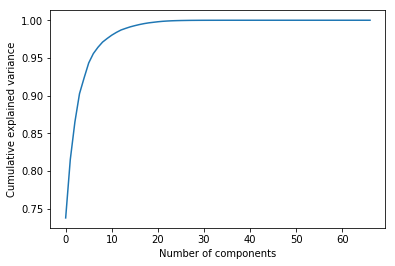

In [38]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance');

In [51]:
variance = pca.explained_variance_ratio_ # calc the variance ratios

var = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
var

array([73.8, 81.5, 86.5, 90.3, 92.4, 94.4, 95.6, 96.4, 97.1, 97.6, 98. ,
       98.4, 98.7, 98.9, 99.1, 99.3, 99.4, 99.5, 99.6, 99.7, 99.8, 99.9,
       99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9,
       99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9,
       99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9,
       99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9,
       99.9])

# Alex's model:

model = Sequential()
model.add(LSTM(100, activation='relu', 
               return_sequences=True, 
               input_shape=(train_data_generator.length, 
                            X_train.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True,
               activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

checkpointer = ModelCheckpoint(filepath='weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5', 
                               verbose=1, 
                               save_best_only=True)

callbacks_list = [checkpointer]

history_2 = model.fit_generator(train_data_generator, 
                              epochs = 50,
                              validation_data=test_data_generator,
                              verbose=1,
                              callbacks=callbacks_list)

## Feature Importances

- Run a XGBoost model to get feature importances to see which ones are important for the pricing.


In [127]:
X_train.head()

,TSLA open,TSLA high,TSLA low,TSLA close,TSLA adj_close,TSLA_vol,TSLA_div,TSLA_coef,XLK open,XLK high,XLK low,XLK close,XLK adj_close,XLK_vol,XLK_div,XLK_coef,vix open,vix high,vix low,vix close,vix adj_close,vix_vol,vix_div,vix_coef,SPX open,SPX high,SPX low,SPX close,SPX adj_close,SPX vol,SPX_div,SPX_coef,TSLA_SMA,TSLA_EMA,TSLA_MACD_Signal,TSLA_MACD_Hist,TSLA_MACD,TSLA_SlowD,TSLA_SlowK,TSLA_RSI,TSLA_ADX,TSLA_CCI,TSLA_Real Middle Band,TSLA_Real Upper Band,TSLA_Real Lower Band,TSLA_Chaikin A/D,TSLA_OBV,housing_index,conf_index,conf_index_SE,trade_value,10 Yrs Rates,20-Yr Maturity Rate,TSLA open_y,TSLA high_y,TSLA low_y,TSLA close_y,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,TSLA_operatingrevenue,TSLA_totalrevenue,TSLA_netincome,TSLA_totaloperatingexpenses,TSLA_totalgrossprofit,TSLA_totaloperatingincome
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-08-24,19.25,19.710,18.95,19.20,19.20,673100.0,0.0,1.0,20.93,21.079,20.77,20.87,17.9672,10590300.0,0.0,1.0,27.91,28.77,26.32,27.46,27.46,0.0,0.0,1.0,1063.20,1063.20,1046.6801,1051.87,1051.87,4.436330e+09,0.0,1.0,19.5775,19.3641,-0.1039,-0.0444,-0.1483,65.1365,64.2590,43.3780,4.5065,-21.9384,19.5775,21.7879,17.3671,-5.397985e+06,-12174000.0,147.552,63.87,3.48,102.4331,3.17,3.28,19.25,19.710,18.95,19.20,19.20,673100.0,0.0,1.0,31241000.0,31241000.0,-34935000.0,47130000.0,9296000.0,-37834000.0
2010-08-25,19.16,19.980,18.56,19.90,19.90,503300.0,0.0,1.0,20.74,21.090,20.69,21.00,18.0791,11052900.0,0.0,1.0,28.30,28.92,26.46,26.70,26.70,0.0,0.0,1.0,1048.98,1059.38,1039.8300,1055.33,1055.33,4.360190e+09,0.0,1.0,19.5365,19.4152,-0.1001,0.0149,-0.0853,67.5305,68.6417,46.1348,4.5061,-3.2187,19.5365,21.6903,17.3827,-4.951395e+06,-11670700.0,147.552,63.87,3.48,102.9749,3.20,3.31,19.16,19.980,18.56,19.90,19.90,503300.0,0.0,1.0,31241000.0,31241000.0,-34935000.0,47130000.0,9296000.0,-37834000.0
2010-08-26,19.89,20.270,19.60,19.75,19.75,433800.0,0.0,1.0,21.10,21.130,20.76,20.79,17.8983,10154700.0,0.0,1.0,26.45,27.55,25.86,27.37,27.37,0.0,0.0,1.0,1056.28,1061.45,1045.4000,1047.22,1047.22,3.646710e+09,0.0,1.0,19.5065,19.4471,-0.0895,0.0426,-0.0469,64.7999,61.4989,45.6336,4.6097,31.2156,19.5065,21.6307,17.3823,-5.190957e+06,-12104500.0,147.552,63.87,3.48,102.9749,3.15,3.25,19.89,20.270,19.60,19.75,19.75,433800.0,0.0,1.0,31241000.0,31241000.0,-34935000.0,47130000.0,9296000.0,-37834000.0
2010-08-27,19.75,19.865,19.50,19.70,19.70,379600.0,0.0,1.0,20.91,21.050,20.58,21.04,18.1136,14991700.0,0.0,1.0,26.50,28.11,24.41,24.45,24.45,0.0,0.0,1.0,1049.27,1065.21,1039.7000,1064.59,1064.59,4.102460e+09,0.0,1.0,19.4945,19.4711,-0.0757,0.0554,-0.0203,66.1105,68.1908,45.4603,4.6664,17.5294,19.4945,21.6114,17.3776,-5.154557e+06,-12484100.0,147.552,63.87,3.48,102.9749,3.31,3.41,19.75,19.865,19.50,19.70,19.70,379600.0,0.0,1.0,31241000.0,31241000.0,-34935000.0,47130000.0,9296000.0,-37834000.0
2010-08-30,19.70,20.190,19.61,19.87,19.87,732800.0,0.0,1.0,20.93,21.090,20.76,20.76,17.8725,7593500.0,0.0,1.0,25.88,27.21,25.41,27.21,27.21,0.0,0.0,1.0,1062.90,1064.40,1048.7900,1048.92,1048.92,2.917990e+09,0.0,1.0,19.4420,19.5091,-0.0576,0.0720,0.0144,65.9999,68.3100,46.1916,4.8434,40.1607,19.4420,21.4649,17.4191,-5.230363e+06,-11751300.0,147.552,63.87,3.48,102.9749,3.19,3.30,19.70,20.190,19.61,19.87,19.87,732800.0,0.0,1.0,31241000.0,31241000.0,-34935000.0,47130000.0,9296000.0,-37834000.0


In [42]:
def get_feature_importance_data(df_new):
    df_copy = df_new.copy()
    y = df_new['target']
    X = df_new.drop(columns='target')
    
    train_samples = int(X.shape[0] * 0.65)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

In [43]:
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(df_new)

In [44]:
# XGBoost model

regressor = xgb.XGBRegressor(gamma=0.0, n_estimators=150, base_score=0.7, colsample_bytree=1, learning_rate=0.05)

xgbModel = regressor.fit(X_train_FI, y_train_FI,
                         eval_set=[(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)],
                         verbose=False)


[14:26:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [45]:
eval_result = regressor.evals_result()

In [46]:
training_rounds = range(len(eval_result['validation_0']['rmse']))

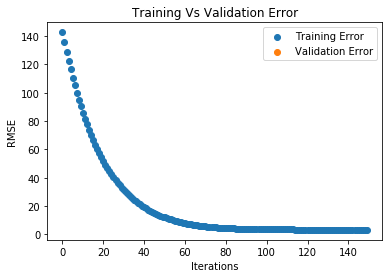

In [47]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

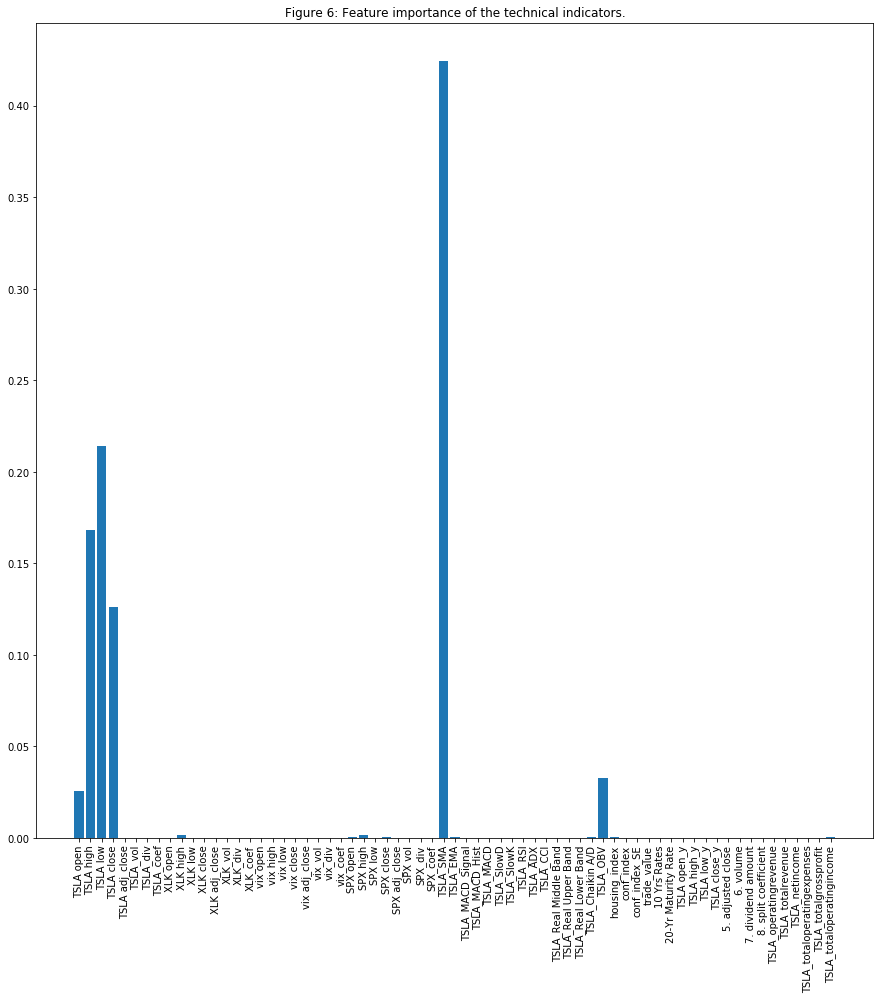

In [48]:
fig = plt.figure(figsize=(15,15))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()

In [54]:
features_import = xgbModel.feature_importances_

In [57]:
!pip install scipy

In [60]:
from scipy import stats

In [65]:
from scipy.stats import weightedtau
from scipy.stats import kendalltau

In [66]:
tau, p_value = stats.weightedtau(var, features_import)

In [67]:
tau

0.0015641061872026657

In [68]:
p_value

nan

In [69]:
tau = stats.kendalltau(var, features_import)
tau

KendalltauResult(correlation=-0.07671209367650055, pvalue=0.4359002930047827)

In [71]:
tau = stats.kendalltau(features_import, var)

tau

KendalltauResult(correlation=-0.07671209367650056, pvalue=0.4359002930047827)

In [ ]:
# aha, made a stupid mistake, shall come back to this

A new approach to activation functions was proposed, showing that NNs work better with GELU as the activation function vs. ReLU, so we are going to give it a shot for autoencoders:
